# Natural Language Processing 2025-1A Homework 3

# Vector Semantics, Word2Vec and LLMs

Deadline: 1 October (23:59)

Questions: Post them in the homework discussion on Canvas, sent them to nlp-course@utwente.nl or ask us during the practical sessions.

How to submit: Please answer the questions directly in this notebook and submit it before the deadline.

## Please Write your group number, your names with student IDs Here:
Assignment Group 35
Kornel Palkovics (s3698920)
Fil Skulimowski (s3295990)

Make sure that the following libraries are up-to-date in your computation envrionment. It is highly recommended to work on this assignment in UT's [JupyterLab](https://www.utwente.nl/en/service-portal/research-support/it-facilities-for-research/jupyterlab).

In [ ]:
!python -m pip install --upgrade pip
!pip3 install gensim nltk scikit-learn numpy pandas scipy
!pip install  --upgrade gensim nltk scikit-learn numpy pandas scipy ### Upgrade your libraries if neccesary

  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)


We'll need these libraries later.

In [ ]:
import pandas, numpy, scipy, math
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
#nltk.download('punkt')
nltk.download('punkt_tab')
from sklearn.metrics.pairwise import cosine_similarity
from gensim.test.utils import datapath
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import codecs
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In this assignment, you will first explore two types of word vectors: those generated using co-occurrence–based methods and those produced by the local-context predictive model Word2Vec. You will then apply and evaluate an NLP task powered by a Large Language Model (LLM).

Note on Terminology:
- The terms "word" and "term" are used interchangeably in this context, referring to unique tokens that you aim to represent as vectors. These tokens can be individual words, n-grams, phrases, or even identifiers, but for this assignment, we will focus on individual words.
- Though "word vectors" and "word embeddings" are often used synonymously, they have distinct meanings.  According to [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding), conceptually, word embedding "*involves the mathematical embedding from space with many dimensions per word to a continuous vector space with a much lower dimension*".

# Part I. Co-occurrence count-based vectors

Let's start with this corpus consisting of 10 sentences.

In [ ]:
sents=[
    "The warm sun melts the icy snow on the mountain.",
    "A warm cup of tea felt perfect in the cool morning air.",
    "Her warm smile brightened the cold winter day.",
    "I love the contrast of a warm blanket on a cold night.",
    "The cold wind chilled me, but the warm fire offered comfort.",
    "After a cold swim, the warm towel felt like heaven.",
    "The warm colors of the sunset clashed with the cold breeze.",
    "The chilly floor left her longing for the cozy comfort of slippers.",
    "A gentle breeze eased the bite of the cold ocean waves.",
    "Cold hands found solace in the warm pockets of his coat."
]


### Exercise 1.1.1 Construct the vocabulary (0.5 point)
Before we construct co-occurrence matrices, we need to identify unique terms in the corpus, i.e. construct the vocabulary. You can remove stop words and apply other text normalisation operations before constructing the vocabulary.

Tip: Sort your vocabulary alphabetically!

In [ ]:
# Collect unique terms in the corpus

# your code starts here

stop_words = set(stopwords.words('english'))

unique_terms = set()

for sentence in sents:
    tokens = word_tokenize(sentence.lower())
    for token in tokens:
        if token.isalpha() and token not in stop_words:
            unique_terms.add(token)

vocab = sorted(list(unique_terms))

# your code ends here

print('The size of the vocabulary is', len(vocab))
print('The word in the vocabulary are', vocab)

The size of the vocabulary is 51
The word in the vocabulary are ['air', 'bite', 'blanket', 'breeze', 'brightened', 'chilled', 'chilly', 'clashed', 'coat', 'cold', 'colors', 'comfort', 'contrast', 'cool', 'cozy', 'cup', 'day', 'eased', 'felt', 'fire', 'floor', 'found', 'gentle', 'hands', 'heaven', 'icy', 'left', 'like', 'longing', 'love', 'melts', 'morning', 'mountain', 'night', 'ocean', 'offered', 'perfect', 'pockets', 'slippers', 'smile', 'snow', 'solace', 'sun', 'sunset', 'swim', 'tea', 'towel', 'warm', 'waves', 'wind', 'winter']


### Co-Occurrence

A co-occurrence matrix counts how often terms co-occur in certain context. The context can be a complete document, a sentence, or a sliding window.

Tip: Check out the [sklearn.feature_extraction.text](https://scikit-learn.org/stable/api/sklearn.feature_extraction.html#module-sklearn.feature_extraction.text) submodule that gathers utilities to build feature vectors from text documents.

### Exercise 1.1.2 Term-document occurrence matrix and term-term co-occurrence matrix (0.5 point)
Let's first consider **each sentence** in the above corpus to be the context where the (co-)occurrences are counted. For example, the words *warm*, *sun*, *icy* and *snow* occur in the first sentence, therefore, they occur in this document and co-occur with each other. Going through all the sentences, you can construct the term-document occurrence matrix and term-term co-occurrence matrix.

In [ ]:
# Construct the term-document occurrence matrix

# your code starts here
vectorizer = CountVectorizer(vocabulary=vocab, lowercase=True, token_pattern=r'\b[a-z]+\b')
tdMatrix_sparse = vectorizer.fit_transform(sents)
tdMatrix = tdMatrix_sparse.T.toarray()


# your code ends here

print('The shape of the term-document matrix is', tdMatrix.shape)
tdMatrix_pd = pandas.DataFrame(tdMatrix, index=vocab, columns=list(range(1, len(sents)+1)))
tdMatrix_pd

The shape of the term-document matrix is (51, 10)


,1,2,3,4,5,6,7,8,9,10
air,0,1,0,0,0,0,0,0,0,0
bite,0,0,0,0,0,0,0,0,1,0
blanket,0,0,0,1,0,0,0,0,0,0
breeze,0,0,0,0,0,0,1,0,1,0
brightened,0,0,1,0,0,0,0,0,0,0
chilled,0,0,0,0,1,0,0,0,0,0
chilly,0,0,0,0,0,0,0,1,0,0
clashed,0,0,0,0,0,0,1,0,0,0
coat,0,0,0,0,0,0,0,0,0,1
cold,0,0,1,1,1,1,1,0,1,1


The term–term co-occurrence matrix can be computed directly from the term–document occurrence matrix. When doing so, pay close attention to the diagonal entries — they indicate self-co-occurrences, which may need to be removed or adjusted depending on your application.

In [ ]:
# Construct the term-term co-occurrence matrix
# Be sure to handle the diagonal elements appropriately

# your code starts here
ttMatrix = tdMatrix @ tdMatrix.T
numpy.fill_diagonal(ttMatrix, 0)


# your code ends here
print('The shape of the term-term matrix is', ttMatrix.shape)
ttMatrix_pd = pandas.DataFrame(ttMatrix, index=vocab, columns=vocab)
ttMatrix_pd



The shape of the term-term matrix is (51, 51)


,air,bite,blanket,breeze,brightened,chilled,chilly,clashed,coat,cold,...,solace,sun,sunset,swim,tea,towel,warm,waves,wind,winter
air,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
bite,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
blanket,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
breeze,0,1,0,0,0,0,0,1,0,2,...,0,0,1,0,0,0,1,1,0,0
brightened,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
chilled,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
chilly,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
clashed,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
coat,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
cold,0,1,1,2,1,1,0,1,1,0,...,1,0,1,1,0,1,6,1,1,1


Based on term-term co-occurrence matrix, which pair(s) of words co-occur the most?

**YOUR ANSWER**:
cold and warm



## Exercise 1.2 Cosine similarity
The benefit of vector semantics is that the similarity of two words can be computed as the cosine similarity between their vectors. Let's now compare how similar two words are.

### Exercise 1.2.1 Calculate cosine similarity between words (0.5 point)

What is the cosine similarity between "cold" and "warm" if 1) using term-document occurrence matrix 2) using term-term co-occurrence matrix?

You may write your own cosine similarity function or use [`sklearn.metrics.pairwise.cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to calculate the pair-wise cosine similarity among all the words.

In [ ]:
# Calculate the cosine similarity between "cold" and "ward" using 1) using term-document occurrence matrix,
# and 2) term-term co-occurrence matrix

# your code starts here

cold_idx = vocab.index('cold')
warm_idx = vocab.index('warm')

# 1) Cosine similarity using term-document occurrence matrix
cold_td_vector = tdMatrix[cold_idx].reshape(1, -1)
warm_td_vector = tdMatrix[warm_idx].reshape(1, -1)

cosine_sim_td = cosine_similarity(cold_td_vector, warm_td_vector)[0][0]
print(f"\nCosine similarity between 'cold' and 'warm': {cosine_sim_td:.4f}")

# 2) Cosine similarity using term-term co-occurrence matrix
cold_tt_vector = ttMatrix[cold_idx].reshape(1, -1)
warm_tt_vector = ttMatrix[warm_idx].reshape(1, -1)

cosine_sim_tt = cosine_similarity(cold_tt_vector, warm_tt_vector)[0][0]
print(f"\nCosine similarity between 'cold' and 'warm': {cosine_sim_tt:.4f}")
# your code ends here


Cosine similarity between 'cold' and 'warm': 0.8018

Cosine similarity between 'cold' and 'warm': 0.3922


### Exercise 1.2.2 (0.5 point)

Now we can calculate cosine similarity between words using a co-occurrence matrix. You can choose any previously constructed matrix for the similarity calculation. Rank all the words based on their similarity to the word *cold*.

In [ ]:
# Rank all the words by their similarity to word "cold"

# your code starts here
cold_idx = vocab.index('cold')
cold_vector = ttMatrix[cold_idx].reshape(1, -1)

similarities = []
for i, word in enumerate(vocab):
    if word != 'cold':
        word_vector = ttMatrix[i].reshape(1, -1)
        similarity = cosine_similarity(cold_vector, word_vector)[0][0]
        similarities.append((word, similarity))

similarities.sort(key=lambda x: x[1], reverse=True)

for rank, (word, sim) in enumerate(similarities[:20], 1):
    print(f"{rank:<6} {word:<20} {sim:.4f}")


# your code ends here

1      clashed              0.5307
2      colors               0.5307
3      sunset               0.5307
4      felt                 0.4903
5      like                 0.4845
6      chilled              0.4845
7      coat                 0.4845
8      fire                 0.4845
9      found                0.4845
10     hands                0.4845
11     heaven               0.4845
12     offered              0.4845
13     pockets              0.4845
14     solace               0.4845
15     swim                 0.4845
16     towel                0.4845
17     wind                 0.4845
18     love                 0.4777
19     night                0.4777
20     smile                0.4777


The calculated cosine similarity does not appear to capture semantic similarity or relatedness reliably. How might we obtain more meaningful similarity measures?

**YOUR ANSWER**:

We could obtain a more meaningful measure the following ways:
- have a larger corpus
- apply TF-IDF weighting
- use context windows around words
- word embeddings like Word2Vex
- use syntactic information by weighing co-occurences by gramatical relationshops (e.g adjective-noun pairs)

# Exercise 1.3 TF-IDF

## Excercise 1.3.1 (0.5 point)
For the above corpus, construct a TF-IDF weighted term-document matrix, using [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [ ]:
# Construct a TF-IDF weighted term-document matrix

# your code starts here
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab, lowercase=True, token_pattern=r'\b[a-z]+\b')

tfidf_matrix_sparse = tfidf_vectorizer.fit_transform(sents)

tfidf_matrix = tfidf_matrix_sparse.T.toarray()

print('The shape of the TF-IDF term-document matrix is', tfidf_matrix.shape)
tfidf_matrix_pd = pandas.DataFrame(tfidf_matrix, index=vocab, columns=list(range(1, len(sents)+1)))
tfidf_matrix_pd
# your code ends here

The shape of the TF-IDF term-document matrix is (51, 10)


,1,2,3,4,5,6,7,8,9,10
air,0.000000,0.380151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bite,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.409607,0.000000
blanket,0.000000,0.000000,0.000000,0.474864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
breeze,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416925,0.000000,0.348203,0.000000
brightened,0.000000,0.000000,0.474864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chilled,0.000000,0.000000,0.000000,0.000000,0.440339,0.000000,0.000000,0.000000,0.000000,0.000000
chilly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.385682,0.000000,0.000000
clashed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.490448,0.000000,0.000000,0.000000
coat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428956
cold,0.000000,0.000000,0.231477,0.231477,0.214647,0.214647,0.239073,0.000000,0.199666,0.209099


Compute and rank the words in descending order based on their similarity to *cold*.

In [ ]:
# Compute and rank the words in descending order based on their similarity to *cold*

# Your code starts here
cold_idx = vocab.index('cold')
cold_tfidf_vector = tfidf_matrix[cold_idx].reshape(1, -1)

similarities_tfidf = []
for i, word in enumerate(vocab):
    if word != 'cold':
        word_tfidf_vector = tfidf_matrix[i].reshape(1, -1)
        similarity = cosine_similarity(cold_tfidf_vector, word_tfidf_vector)[0][0]
        similarities_tfidf.append((word, similarity))

similarities_tfidf.sort(key=lambda x: x[1], reverse=True)

for rank, (word, sim) in enumerate(similarities_tfidf[:20], 1):
    print(f"{rank:<6} {word:<20} {sim:.4f}")

# Your code ends here

1      warm                 0.8348
2      breeze               0.5341
3      clashed              0.4100
4      colors               0.4100
5      sunset               0.4100
6      blanket              0.3969
7      brightened           0.3969
8      contrast             0.3969
9      day                  0.3969
10     love                 0.3969
11     night                0.3969
12     smile                0.3969
13     winter               0.3969
14     chilled              0.3681
15     fire                 0.3681
16     heaven               0.3681
17     like                 0.3681
18     offered              0.3681
19     swim                 0.3681
20     towel                0.3681


## Exercise 1.3.2 (0.5 point)

Let's use a bigger dataset which contains 2225 BBC news articles to construct TF-IDF term-document matrix.

In [ ]:
sents=codecs.open('bbc-text.csv','r', encoding='utf-8').readlines() # load the data

# your code starts here
documents = []
for i, line in enumerate(sents):
    if i == 0:
        continue
    parts = line.strip().split(',', 1)
    if len(parts) == 2:
        documents.append(parts[1])

stop_words = set(stopwords.words('english'))

tfidf_vectorizer_bbc = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    min_df=2,
    max_df=0.85,
    token_pattern=r'\b[a-z]{2,}\b'
)

term_doc_matrix = tfidf_vectorizer_bbc.fit_transform(documents)
vocab = tfidf_vectorizer_bbc.get_feature_names_out()
# your code ends here

print('The size of the vocabulary is', len(vocab))
print('The shape of the term-document matrix is', term_doc_matrix.shape)



The size of the vocabulary is 16692
The shape of the term-document matrix is (2225, 16692)


We can compute which words are most similar to *cold*. Does this list of words make more sense now and why?

**YOUR ANSWER**:
It makes a bit more sense, because we have a larger corpus to train on resulting in better statistics and reduced noise. Although the list is domain specific, I can see a pattern emergin on how cold increases energy demand, which alters oil prices, so in that context the words like opec, heating, insulation make sense.


In [ ]:
# Find the top 10 words that are most similar to word "cold"

# your code starts here

cold_idx = list(vocab).index('cold')

term_doc_matrix_T = term_doc_matrix.T
cold_vector = term_doc_matrix_T[cold_idx]


similarities_bbc = cosine_similarity(cold_vector, term_doc_matrix_T)[0]

word_similarities = []
for i, word in enumerate(vocab):
    if word != 'cold':
        word_similarities.append((word, similarities_bbc[i]))

word_similarities.sort(key=lambda x: x[1], reverse=True)

for rank, (word, sim) in enumerate(word_similarities[:10], 1):
    print(f"{rank:<6} {word:<20} {sim:.4f}")


# your code ends here

1      opec                 0.4756
2      crude                0.4321
3      heating              0.4218
4      brent                0.3968
5      cartel               0.3841
6      barrel               0.3835
7      conservation         0.3760
8      adnan                0.3720
9      eldin                0.3720
10     retreated            0.3720


Find another 3 pairs of words whose cosine similarity makes sense to you.

In [ ]:
# Look for 3 pairs of words whose cosine similarities reflect their semantic similarity or relatedness.

word_pairs = [
    ('government', 'minister'),
    ('football', 'match'),
    ('market', 'economy')
]

term_doc_matrix_T = term_doc_matrix.T

for word1, word2 in word_pairs:
    if word1 in vocab and word2 in vocab:
        idx1 = list(vocab).index(word1)
        idx2 = list(vocab).index(word2)

        vec1 = term_doc_matrix_T[idx1]
        vec2 = term_doc_matrix_T[idx2]
        similarity = cosine_similarity(vec1, vec2)[0][0]

        print(f"{word1:<20} {word2:<20} {similarity:.4f}")

government           minister             0.3982
football             match                0.1204
market               economy              0.1564


The chosen word pairs have lower correlation in the BBC corpus than I was expecting.

# Part II. Word2Vec word vectors

Here, we explore the embeddings produced by word2vec. Please read J&M 6.8 or the [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) if you are interested in the details of the algorithm.

## Exercise 2.1 Pre-train word2vec model

Run the following script to load the word2vec vectors into memory. **Note**: This might take several minutes. If you run out of memory, try closing other applicaions or restart your machine to free more memory.

Please note, the following experiments run with Gensim 4.3.3. If you are still running an old version of Gensim, please upgrade your Gensim library or check [Migrating from Gensim 3.x to 4](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4) to adapt your code.

In [ ]:
# Load 3 million Word2Vec Vectors, pre-trained on Google news, each with the dimension of 300
# This model may take a few minutes to load.

import gensim.downloader as api
start_time = time.time()
w2v_google = api.load("word2vec-google-news-300")
print("--- %s seconds ---" % (time.time() - start_time))

[==================================================] 100.0% 1662.8/1662.8MB downloaded
--- 284.264235496521 seconds ---


In [ ]:
print("Loaded vocab size {}".format(len(w2v_google.index_to_key)))

Loaded vocab size 3000000


Once the model is loaded, you can extract the vector for individual words directly using `wv_google['']`

In [ ]:
w2v_google['cold']

array([-1.89208984e-02,  1.18652344e-01, -6.25000000e-02,  7.86132812e-02,
       -3.46679688e-02,  2.51953125e-01,  2.06298828e-02, -1.64062500e-01,
       -2.12402344e-02,  3.18359375e-01,  6.93359375e-02, -1.56250000e-01,
       -4.80957031e-02, -4.63485718e-04,  1.45874023e-02, -7.04956055e-03,
       -1.00708008e-03, -2.00195312e-02,  1.53320312e-01, -2.53906250e-01,
        4.08935547e-03,  1.51367188e-01, -5.88378906e-02, -1.30859375e-01,
        1.79687500e-01, -5.00488281e-03,  7.61718750e-02,  1.09863281e-01,
       -2.19726562e-01, -4.15039062e-02, -6.93359375e-02,  6.98242188e-02,
        2.49023438e-01,  1.29882812e-01, -2.85156250e-01, -7.95898438e-02,
       -1.04003906e-01,  1.95312500e-02,  1.42578125e-01,  1.08886719e-01,
        2.07031250e-01, -2.94921875e-01,  1.50390625e-01, -1.65039062e-01,
       -4.05273438e-02,  3.11279297e-02, -2.59765625e-01,  3.63769531e-02,
       -1.67968750e-01,  2.14843750e-01,  7.32421875e-02,  1.65039062e-01,
       -2.35351562e-01,  

One of the property of semantic embedding is that similar words are embedded close to each other. Use  `w2v_google.most_similar()` to identify the most similar words to *north*. Does this list make more sense to you?

In [ ]:
start_time = time.time()
for w,c in w2v_google.most_similar('cold'):
    print(w,c)
print("--- %s seconds ---" % (time.time() - start_time))

chilly 0.6878557205200195
frigid 0.6770406365394592
Cold 0.6727538704872131
bitterly_cold 0.6375916600227356
chill 0.6324006915092468
warm 0.5953035950660706
colder 0.590000331401825
TONIGHT_Clear 0.5773205757141113
frosty 0.5743643045425415
frigid_weather 0.5725992918014526
--- 6.982366561889648 seconds ---


Check a few more words to see whether their most similar words make sense to you and explain why.

In [ ]:
w2v_google.most_similar('black')

[('white', 0.8092213869094849),
 ('Responded_Letterman_How', 0.6182776689529419),
 ('blacks', 0.589222252368927),
 ('crypt_inscribed', 0.5855618119239807),
 ('transporting_petrochemicals', 0.5834174752235413),
 ('brown', 0.5766680240631104),
 ('Shilah_Phillips', 0.5763780474662781),
 ('women_dating_interracially', 0.5670552253723145),
 ('wrote_Newitz', 0.5604413747787476),
 ('blue', 0.5492398142814636)]

The word similarities make more sense here, except for some outliers. For example for 'black' we have 'Responded_Letterman_How', 'crypt_inscribed' or 'wrote_Newitz' on the list, but for the word 'cat' the list makes a lot of sense.

## Word analogies

An analogy explains one thing in terms of another to highlight the ways in which they are alike. For example, *paris* is similar to *france* in the same way that *rome* is to *italy*. Word2Vec vectors sometimes shows the ability of solving analogy problem of the form **a is to b as a* is to what?**.

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value). In the case below, the top one word *italy* is the answer, so this analogy is solved successfully.

In [ ]:
# Run this cell to answer the analogy -- paris : france :: rome : x
print(w2v_google.most_similar(positive=['rome', 'france'], negative=['paris']))

[('italy', 0.519952118396759), ('european', 0.5075845718383789), ('italian', 0.5057743191719055), ('epl', 0.490744411945343), ('spain', 0.4888668656349182), ('england', 0.4852672219276428), ('italians', 0.4842422604560852), ('kosovo', 0.48134922981262207), ('lampard', 0.4807734787464142), ('malta', 0.4788566529750824)]


### Exercise 2.1.1 (0.5 point)
Look for one analogy that can be solved successfully and one analogy that could not be solved using this pre-trained Word2Vec model. Check out [this paper](https://www.semanticscholar.org/paper/Efficient-Estimation-of-Word-Representations-in-Mikolov-Chen/330da625c15427c6e42ccfa3b747fb29e5835bf0) for inspirations.

In [ ]:
# Your successful case goes here
print("king is to man as queen is to ___?")
result = w2v_google.most_similar(positive=['queen', 'man'], negative=['king'], topn=10)
for i, (word, score) in enumerate(result, 1):
    print(f"  {i}. {word:<15} (similarity: {score:.4f})")

# Your failed case goes here
print("\nAnalogy: water is to wet as fire is to ___?")
result = w2v_google.most_similar(positive=['fire', 'wet'], negative=['water'], topn=10)
for i, (word, score) in enumerate(result, 1):
    print(f"  {i}. {word:<15} (similarity: {score:.4f})")

king is to man as queen is to ___?
  1. woman           (similarity: 0.7609)
  2. girl            (similarity: 0.6140)
  3. teenage_girl    (similarity: 0.6041)
  4. teenager        (similarity: 0.5826)
  5. lady            (similarity: 0.5753)
  6. boy             (similarity: 0.5078)
  7. policewoman     (similarity: 0.5067)
  8. schoolgirl      (similarity: 0.5052)
  9. blonde          (similarity: 0.4870)
  10. person          (similarity: 0.4864)

Analogy: water is to wet as fire is to ___?
  1. blaze           (similarity: 0.5131)
  2. fires           (similarity: 0.5128)
  3. carelessly_discarded_cigarette (similarity: 0.4777)
  4. discarded_cigarette (similarity: 0.4574)
  5. spontaneous_combustion (similarity: 0.4511)
  6. brush_fires     (similarity: 0.4472)
  7. inferno         (similarity: 0.4396)
  8. blazes          (similarity: 0.4355)
  9. alight          (similarity: 0.4303)
  10. Oily_rags       (similarity: 0.4271)


## Visualising word analogies

The following cell shows you how to use [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to visualise a set of words based on their embeddings. You can also apply other dimensionality reduction methods (e.g. [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)) to reduce the vectors from 300-dimensional to 2 dimensional.

Please note, reducing dimensionality from 300 to 2 is a very challenging task. You can try different parameters in the tSNE and see their effects on the final visualisation. In particular, the visualisation is very sensitive to the perplexity value that you give. Please try a few different perplexity valuse and keep the one that gives the most reasonable visusalisation.

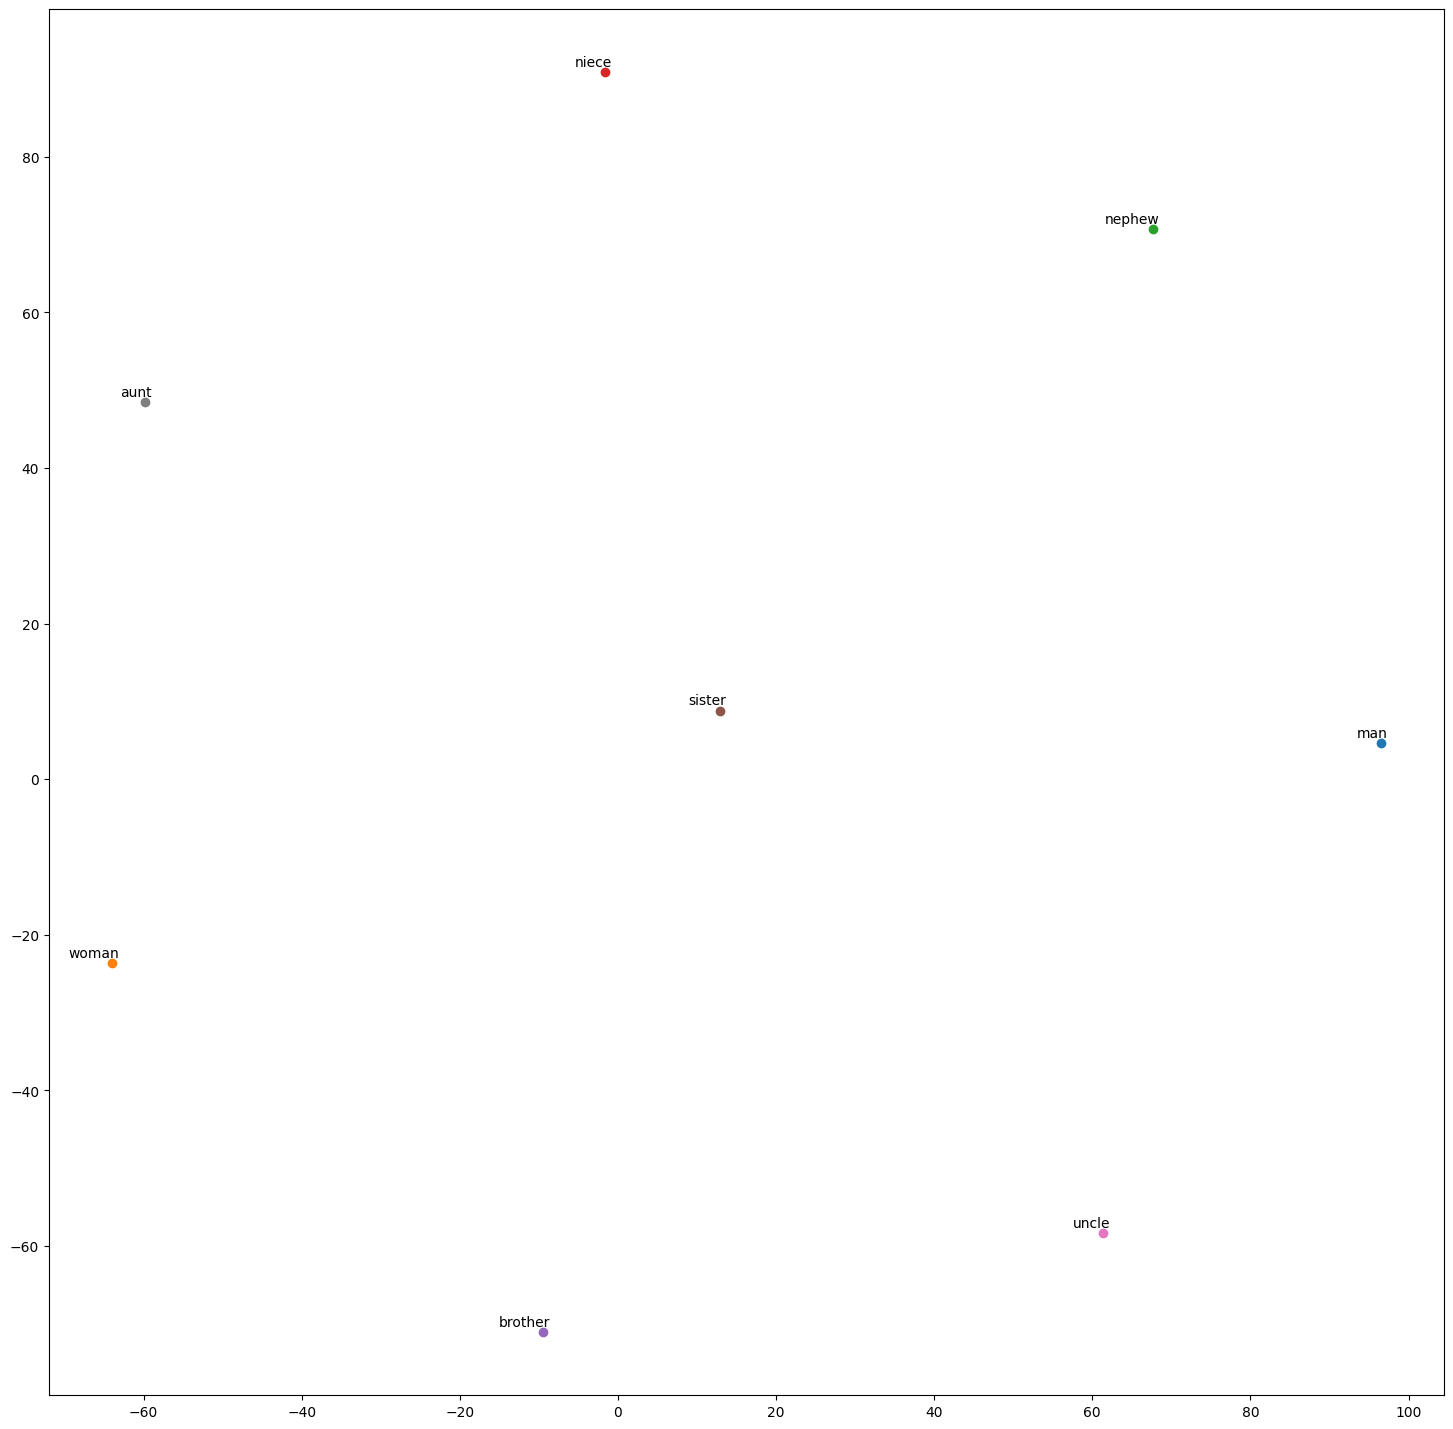

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def tsne_plot(model, wordlist, p):
    labels = []
    tokens = []

    for word in wordlist:
        tokens.append(model[word])
        labels.append(word)

    tokens = np.array(tokens)

    tsne_model = TSNE(perplexity=p, n_components=2, init='pca', max_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(18, 18))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

wordlist = ['man', 'woman', 'nephew', 'niece', 'brother', 'sister', 'uncle', 'aunt']
tsne_plot(w2v_google, wordlist, len(wordlist) - 1)


### Exercise 2.1.2 (0.5 point)
Find another group analogies (at least 3 pairs of words) and see how they are visualised.  

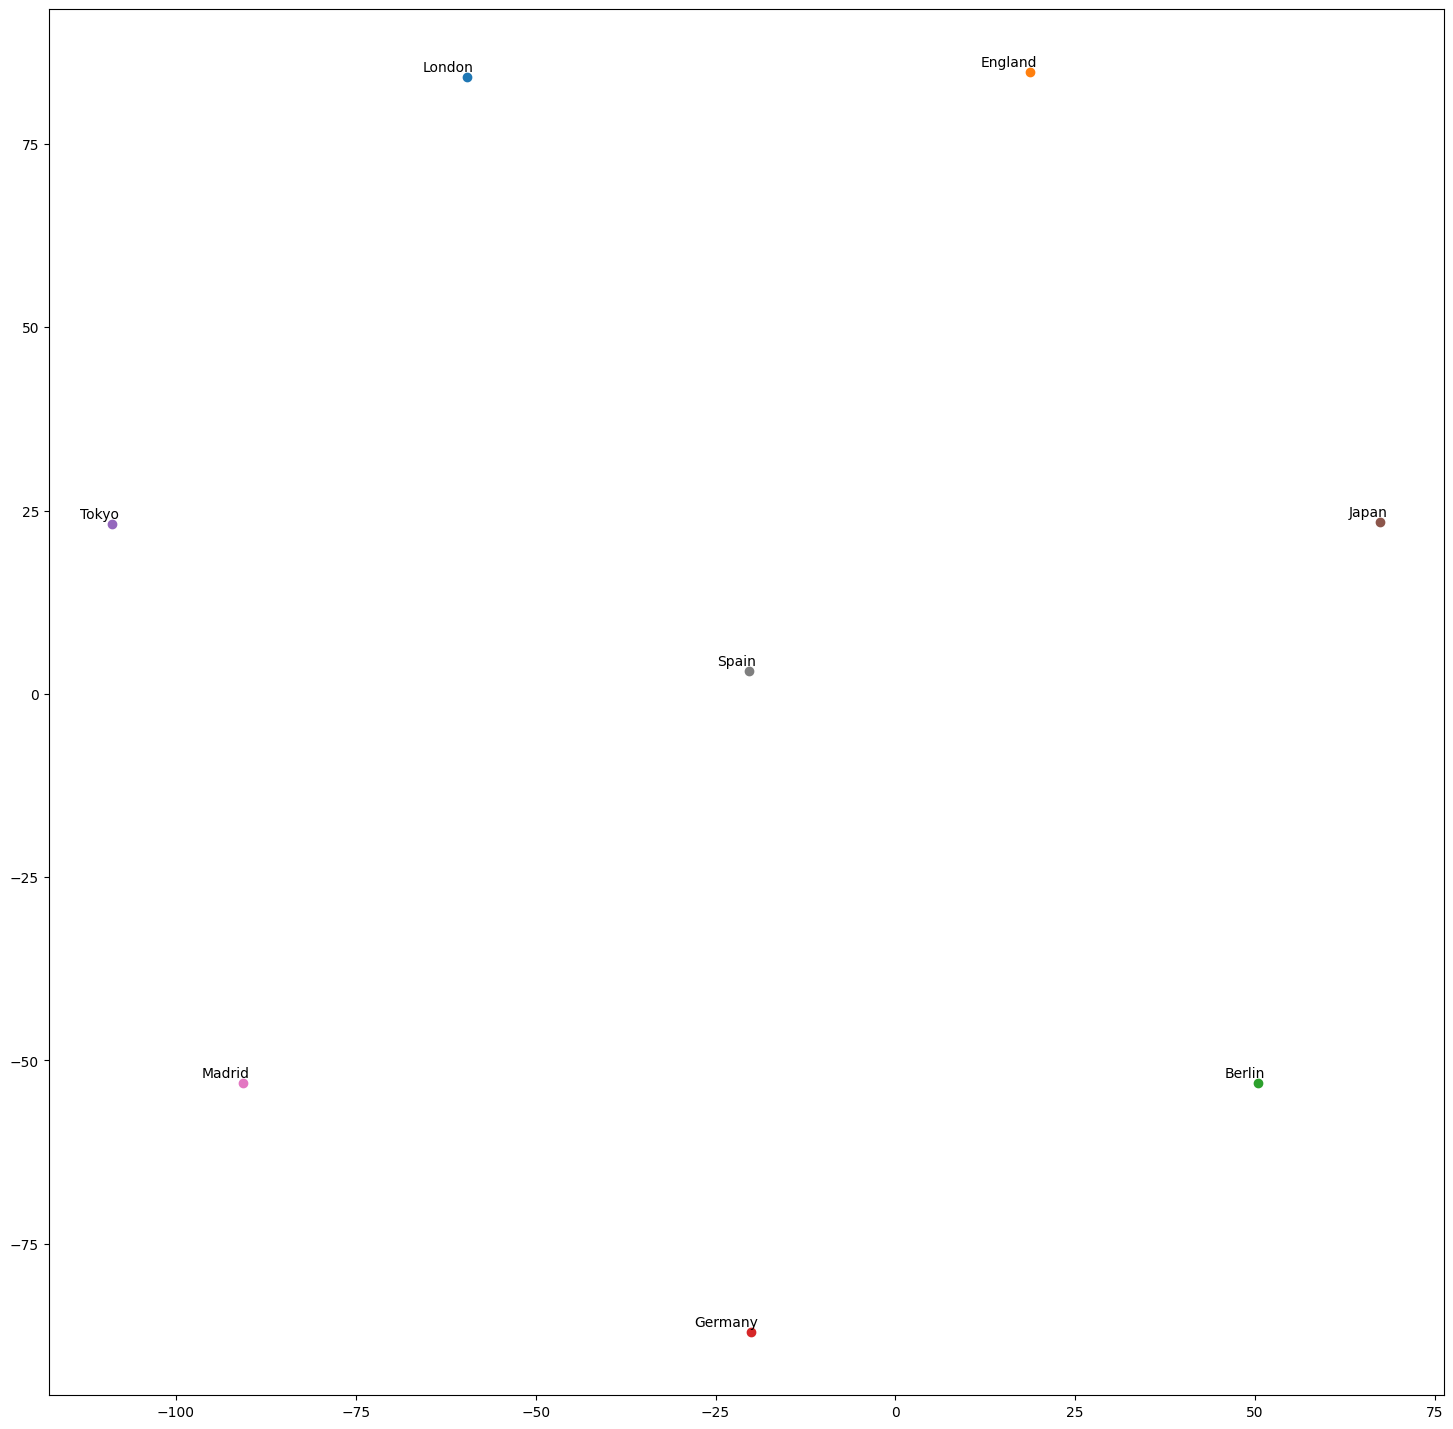

In [ ]:
# prepare at least 3 pairs of words

# your answer goes here

wordlist = [
    'London', 'England',
    'Berlin', 'Germany',
    'Tokyo', 'Japan',
    'Madrid', 'Spain'
]
p=len(wordlist)-1
tsne_plot(w2v_google,wordlist,p)

### Exercise 2.1.3  Synonyms and antonyms (0.5 point)



Find three words (w1, w2, w3) so that
- w1 and w2 are synonyms,
- w1 and w3 are antonyms,
- cosine_distance(w1, w2) > cosine_distance(w1, w3) or cosine_distance(w1, w2) $\approx$ cosine_distance(w1, w3).

Please give a possible explanation for why this has happened.

You can use [`w2v_google.distance()`](https://radimrehurek.com/gensim/models/keyedvectors.html) function to compute the cosine distance between two words.

In [ ]:
# Replace XXX, YYY and ZZZ with your chosen words

w1 = 'good'
w2 = 'great'
w3 = 'bad'

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w2v_google.distance(w1, w2)))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w2v_google.distance(w1, w3)))


Synonyms good, great have cosine distance: 0.27084898948669434
Antonyms good, bad have cosine distance: 0.28099489212036133


**Your answer**:
The antonyms are closer because they have a similar context (good vs bad) and they usually co-occur more in patterns, because they often evaluate the same thing. Whereas the synonyms are most distant because 'great' is more intense than 'good', so they might appear in slightly different context. Also 'good' and 'great' have different distributions too, because 'good' is more common to appear in text. Lastly they are not as interchangeable as 'good' and 'bad' could be.


### Exercise 2.1.4 Polysemous Words (0.5 point)

Some words are polysemous, i.e. they have multiple meanings. For example the word *bank* can be a financial institute or the rising ground bordering a lake or river. Find a polysemous word whose top most similar words contains related words from multiple meanings. You should use the the [`wv_google.most_similar()`](https://radimrehurek.com/gensim/models/keyedvectors.html) function to compute the closet neighbours of the word. You may increase the number of neighbours in order to identify multiple groups of meanings. Submit the ranked word list and explained how the words are grouped into different meanings.

In [ ]:
w2v_google.most_similar('crane',topn=50)

[('cranes', 0.7692900896072388),
 ('scaffolding', 0.6770226955413818),
 ('cherry_picker', 0.6515053510665894),
 ('hydraulic_crane', 0.6279746890068054),
 ('girder', 0.623549222946167),
 ('forklift', 0.6210452914237976),
 ('gantry_crane', 0.6148872375488281),
 ('crane_toppled', 0.6126982569694519),
 ('excavator', 0.6093015670776367),
 ('tower_cranes', 0.6078611612319946),
 ('manlift', 0.6062108278274536),
 ('cherrypicker', 0.5868619084358215),
 ('winch', 0.5834875702857971),
 ('scaffold', 0.5760444402694702),
 ('overhead_cranes', 0.5720781683921814),
 ('crawler_crane', 0.5694176554679871),
 ('steel_girder', 0.5667331218719482),
 ('pallet_jack', 0.5615602731704712),
 ('crane_barge', 0.5610539317131042),
 ('trackhoe', 0.5599021315574646),
 ('crane_operator', 0.558091402053833),
 ('girders', 0.5569372177124023),
 ('hydraulic_jacks', 0.551821231842041),
 ('falsework', 0.5491117238998413),
 ('fork_lift', 0.5467649698257446),
 ('telescopic_boom', 0.5462592840194702),
 ('payloader', 0.54228931

['crane', 'cranes', 'scaffolding', 'cherry_picker', 'hydraulic_crane', 'girder', 'forklift', 'gantry_crane', 'crane_toppled', 'excavator', 'tower_cranes', 'manlift', 'cherrypicker', 'winch', 'scaffold', 'overhead_cranes', 'crawler_crane', 'steel_girder', 'pallet_jack', 'crane_barge', 'trackhoe', 'crane_operator', 'girders', 'hydraulic_jacks', 'falsework', 'fork_lift', 'telescopic_boom', 'payloader', 'barge', 'ton_girder', 'hydraulic_cranes', 'concrete_girder', 'flatbed_tractor_trailer', 'fiberglass_walleye', 'flatbed_truck', 'launching_girder', 'steel_girders', 'bosun_chair', 'hydraulic_excavator', 'backhoe', 'jib_crane', 'telehandler', 'steel_beams', 'crawler_cranes', 'truss', 'concrete_girders', 'luffing_jib', 'scaffolding_collapsed', 'scissor_lift', 'crane_rigger', 'crane_hoists', 'telescopic_crane', 'gantry', 'roof_trusses', 'gantry_cranes', '###ft_crane', 'flatbed_trailer', 'nylon_slings', 'elevator_shaft', 'pontoons', 'derrick', 'hydraulic_lift', 'steel_trusses', 'trusses', 'pont

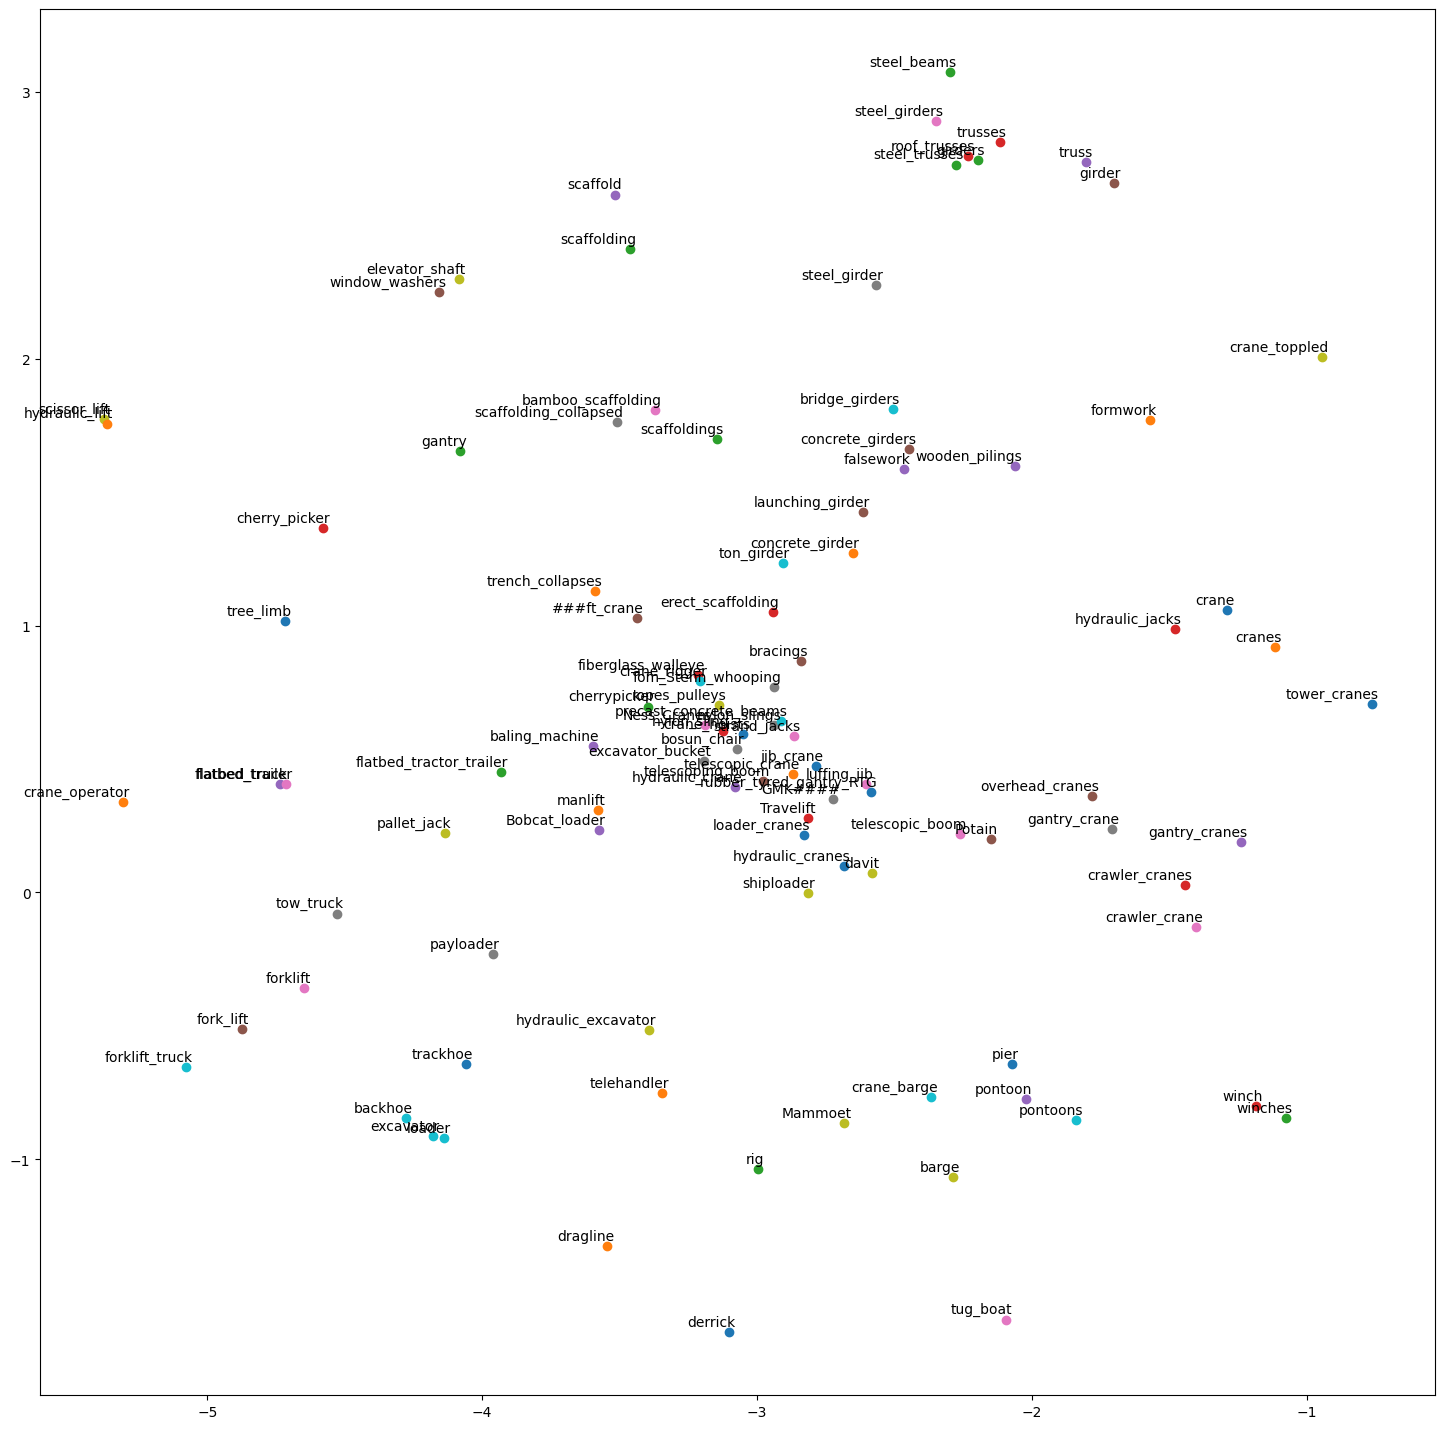

In [ ]:
focusword='crane'
wordlist=[focusword]
for w in w2v_google.most_similar(focusword,topn=100):
    wordlist.append(w[0])
print(wordlist)
tsne_plot(w2v_google,wordlist,50)

Look into literature and describe potential methods to address this polysymy issue in word embeddings. Please cite the papers that you refer to.

**YOUR ANSWER**:

1) One approach to tackle the polysemy problem is using multi-prototype word embedding. These methods learn multiple vectors per word, one for each sense.
References:

Huang et al. (2012) - "Improving Word Representations via Global Context and Multiple Word Prototypes"

Neelakantan et al. (2014)- "Efficient Non-parametric Estimation of Multiple Embeddings per Word in Vector Space"

2) Another approach would be to use contextualized word embeddings, which generate different meaning based on context.

Used in:

Peters et al. (2018) - ELMo (Embeddings from Language Models)

Devlin et al. (2019) - BERT (Bidirectional Encoder Representations from Transformers)

3) Third, we could use sparse coding and decomposition.

Reference:

Arora et al. (2018) - "Linear Algebraic Structure of Word Senses"



## Exercise 2.2  Self-trained Word2Vec model

The word2vec model that we have been using so far is pre-trained on Google news. This is suitable for applications involving general topics. However, for special domains, such as scientific or medical domain, some domain-specific semantics could not be captured in the pre-trained model. Fortunately, word2vec is pretty efficient in training from scratch. We will use two different datasets to observer the effect on the input corpus.

Importance parameters are highlighted in bold. Please choose a few different values and see their effects.  

class gensim.models.word2vec.Word2Vec(sentences=None, corpus_file=None, **vector_size=100**, alpha=0.025, **window=5**, **min_count=5**, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, **sg=0**, hs=0, **negative=5**, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), comment=None, max_final_vocab=None, shrink_windows=True)
    
Please check the [gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more assistance.

In [ ]:
# the most similar words to 'young' in Google news
w2v_google.most_similar('young')

[('By_Yoon_Ja', 0.678579568862915),
 ('By_Soh_Ji', 0.66059809923172),
 ('teenage', 0.6431925296783447),
 ('younger', 0.635094165802002),
 ('teenaged', 0.6070023775100708),
 ('impressionable', 0.5947335362434387),
 ('horribly_horribly_deranged', 0.5760281085968018),
 ('youth', 0.5715782642364502),
 ('neglected_clearcut', 0.5711859464645386),
 ('Chung_Ah', 0.5690588355064392)]

### Exercise 2.2.1 (1 point)

We first train a word2vec model on the corpus consisting the abstracts from 111K astrophysics/astronomy articles.

In [ ]:

# This might take up a few minutes to train.
from gensim.models.word2vec import LineSentence, Word2Vec
sentences=LineSentence('astro_norm.txt')

start_time = time.time()
# Train a word2vec model using the astro dataset
# your code starts here

w2v_astro = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    sg=0,
    negative=5,
    workers=4,
    epochs=5
)

# your code ends here
print("--- %s seconds ---" % (time.time() - start_time))

--- 81.8929340839386 seconds ---


In [ ]:
w2v_astro.wv.most_similar('young')

[('old', 0.7046900987625122),
 ('ob', 0.6711347103118896),
 ('youngest', 0.6498962640762329),
 ('ysos', 0.6190456748008728),
 ('proto', 0.6049332618713379),
 ('nearby', 0.602557897567749),
 ('compact', 0.5907571911811829),
 ('associations', 0.5882768034934998),
 ('yso', 0.5832907557487488),
 ('massive', 0.5795160531997681)]

If all goes well, you may see *pms*, *proto* or *yso* among the top 10 most similar words to *young*. If you are curious, protostars and pre-main-sequence (PMS) stars are all [Young Stella Objects](https://en.wikipedia.org/wiki/Young_stellar_object)  (YSOs). Here, “young” means pre-main-sequence. For low-mass stars, this means ages of $10^5$ to $10^8$ years. [Ref](https://nexsci.caltech.edu/workshop/2003/2003_MSS/10_Thursday/mss2003_jensen.pdf)

We then train a word2vec model on the corpus consisting of nearly 479K [Medline](https://www.nlm.nih.gov/medline/medline_overview.html) articles. Note, this corpus is rather big. If this is too much for your local machine, use UT's [JupyterLab](https://www.utwente.nl/en/service-portal/research-support/it-facilities-for-research/jupyterlab) or [Google Colab](https://colab.research.google.com/notebooks/).

In [ ]:
# This might take up half an hour to train!

from gensim.models.word2vec import LineSentence, Word2Vec
sentences=LineSentence('medline_norm.txt')

start_time = time.time()
# Train a word2vec model using the astro dataset
# your code starts here

w2v_medline = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    sg=0,
    negative=5,
    workers=4,
    epochs=5
)

# your code ends here
print("--- %s seconds ---" % (time.time() - start_time))

--- 61.572845220565796 seconds ---


In [ ]:
w2v_medline.wv.most_similar('young')

[('older', 0.7365538477897644),
 ('adolescents', 0.7220797538757324),
 ('elderly', 0.7178835272789001),
 ('adolescent', 0.717608630657196),
 ('born', 0.7043596506118774),
 ('adult', 0.7011519074440002),
 ('obese', 0.6986082792282104),
 ('preschool', 0.6828358173370361),
 ('residing', 0.677773118019104),
 ('aboriginal', 0.6712833046913147)]

Find another word and compute its most similar words based on different models. Please explain why this happens.

**YOUR ANSWER**:


 We have chosen the word 'star', because it has different meanings in different context. For example in the general news it can mean a celebrity or an astronomical object, while in astryphysics it is usually referring a stellar object or a specific type of star, and lastly in medicine it might be less common, but it could refer to star-shaped anatomical structures.

In [ ]:
w2v_google.most_similar('star')  # Replace XXX with your chosen word

[('stars', 0.7763954997062683),
 ('superstar', 0.7340598702430725),
 ('starlet', 0.6381064057350159),
 ('megastar', 0.6165120005607605),
 ('heart_throb', 0.5726701617240906),
 ('teen_heart_throb', 0.5503726005554199),
 ('heart_throb_Zac_Efron', 0.5443484783172607),
 ('heartthrob', 0.543801486492157),
 ('superstars', 0.5326131582260132),
 ('standout', 0.5210359692573547)]

In [ ]:
w2v_astro.wv.most_similar('star')

[('stars', 0.7271406650543213),
 ('protostar', 0.5653439164161682),
 ('monitors', 0.5207021236419678),
 ('engine', 0.5091458559036255),
 ('spheroid', 0.5033178925514221),
 ('drip', 0.5009800791740417),
 ('fu', 0.4894684851169586),
 ('stellar', 0.47134047746658325),
 ('object', 0.4683510959148407),
 ('scallop', 0.46531784534454346)]

In [ ]:
w2v_medline.wv.most_similar('star')

[('string', 0.5898801684379578),
 ('wisconsin', 0.5646483302116394),
 ('euroqol', 0.5559050440788269),
 ('card', 0.5543015003204346),
 ('audio', 0.5430412888526917),
 ('likert', 0.5368816256523132),
 ('bref', 0.5307514667510986),
 ('semistructured', 0.5296818017959595),
 ('page', 0.5288043022155762),
 ('28s', 0.5253102779388428)]

**YOUR ANSWER to Why this happens:**

This happens because in different training corpuses, the word has different meanings. Also, Word2Vec learns co-occurence patterns so the algorithm creates vectors by surrounding words with Skip-gram or predicts center words from context with CBOW, resulting in words that appear close to 'star' in eahc corpus to have similar embeddings.

### Exercise 2.2.2 (1 point)

Experiment with different parameters, for example, the vector size, the window size, the minimal count, skip-gram or CBOW, etc. Observe their effects on the quality of the word embeddings and/or computational cost.

You can apply intrinsic evaluations to compare the quality of your models. For example, your can check the correlation with human opinion on word similarity or on word analogies. Check gensim documentations for more options. For example, [evaluate_word_analogies](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_analogies) and [evaluate_word_pairs](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_pairs).


**YOUR ANSWER**:

In [ ]:
import time
import pandas as pd
from gensim.models.word2vec import LineSentence, Word2Vec

# Load the dataset once
print("Loading astrophysics corpus...")
sentences = LineSentence('astro_norm.txt')

# Define parameter configurations to test
# Each configuration is a dictionary with parameter settings and a name
configs = [
    # Baseline configuration (same as Exercise 2.2.1)
    {
        'name': 'Baseline (CBOW)',
        'vector_size': 100,
        'window': 5,
        'min_count': 5,
        'sg': 0,  # CBOW
        'negative': 5,
        'epochs': 5
    },

    # Experiment 1: Skip-gram vs CBOW
    {
        'name': 'Skip-gram',
        'vector_size': 100,
        'window': 5,
        'min_count': 5,
        'sg': 1,  # Skip-gram
        'negative': 5,
        'epochs': 5
    },

    # Experiment 2: Larger vector size
    {
        'name': 'Large vectors (300d)',
        'vector_size': 300,
        'window': 5,
        'min_count': 5,
        'sg': 0,
        'negative': 5,
        'epochs': 5
    },

    # Experiment 3: Smaller vector size
    {
        'name': 'Small vectors (50d)',
        'vector_size': 50,
        'window': 5,
        'min_count': 5,
        'sg': 0,
        'negative': 5,
        'epochs': 5
    },

    # Experiment 4: Larger context window
    {
        'name': 'Large window (10)',
        'vector_size': 100,
        'window': 10,
        'min_count': 5,
        'sg': 0,
        'negative': 5,
        'epochs': 5
    },

    # Experiment 5: Smaller context window
    {
        'name': 'Small window (2)',
        'vector_size': 100,
        'window': 2,
        'min_count': 5,
        'sg': 0,
        'negative': 5,
        'epochs': 5
    },

    # Experiment 6: Lower min_count (more words)
    {
        'name': 'Low min_count (2)',
        'vector_size': 100,
        'window': 5,
        'min_count': 2,
        'sg': 0,
        'negative': 5,
        'epochs': 5
    },

    # Experiment 7: More training epochs
    {
        'name': 'More epochs (10)',
        'vector_size': 100,
        'window': 5,
        'min_count': 5,
        'sg': 0,
        'negative': 5,
        'epochs': 10
    }
]

results = []

print("\n" + "=" * 80)
print("TRAINING AND EVALUATING DIFFERENT WORD2VEC CONFIGURATIONS")
print("=" * 80)

test_words = [
    ('star', 'galaxy'),
    ('hot', 'cold'),
    ('young', 'old'),
    ('large', 'massive'),
    ('disk', 'accretion')
]

for i, config in enumerate(configs, 1):
    print(f"\n[{i}/{len(configs)}] Testing: {config['name']}")
    print("-" * 80)

    sentences = LineSentence('astro_norm.txt')

    start_time = time.time()

    model = Word2Vec(
        sentences=sentences,
        vector_size=config['vector_size'],
        window=config['window'],
        min_count=config['min_count'],
        sg=config['sg'],
        negative=config['negative'],
        workers=4,
        epochs=config['epochs']
    )

    training_time = time.time() - start_time
    vocab_size = len(model.wv)

    print(f"  Training time: {training_time:.2f} seconds")
    print(f"  Vocabulary size: {vocab_size:,} words")

    similarities = []
    for word1, word2 in test_words:
        if word1 in model.wv and word2 in model.wv:
            sim = model.wv.similarity(word1, word2)
            similarities.append(sim)
        else:
            similarities.append(None)

    avg_similarity = sum(s for s in similarities if s is not None) / len([s for s in similarities if s is not None])

    print(f"  Average similarity on test pairs: {avg_similarity:.4f}")

    analogy_score = None
    try:
        if all(w in model.wv for w in ['hot', 'cold', 'young', 'old']):
            analogy_results = model.wv.most_similar(
                positive=['cold', 'young'],
                negative=['hot'],
                topn=10
            )
            # Check if 'old' is in top 10
            analogy_words = [w for w, s in analogy_results]
            if 'old' in analogy_words:
                analogy_rank = analogy_words.index('old') + 1
                analogy_score = analogy_results[analogy_rank - 1][1]
                print(f"  Analogy test: 'old' found at rank {analogy_rank} (score: {analogy_score:.4f})")
            else:
                print(f"  Analogy test: 'old' not in top 10")
                analogy_rank = None
    except Exception as e:
        print(f"  Analogy test failed: {str(e)[:50]}")
        analogy_rank = None

    # Store results
    results.append({
        'Configuration': config['name'],
        'Vector Size': config['vector_size'],
        'Window': config['window'],
        'Min Count': config['min_count'],
        'Algorithm': 'Skip-gram' if config['sg'] == 1 else 'CBOW',
        'Epochs': config['epochs'],
        'Training Time (s)': round(training_time, 2),
        'Vocab Size': vocab_size,
        'Avg Similarity': round(avg_similarity, 4),
        'Analogy Rank': analogy_rank if analogy_rank else '>10'
    })

# Create summary table
print("\n" + "=" * 80)
print("SUMMARY OF RESULTS")
print("=" * 80)

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Save the baseline model for later comparison
sentences = LineSentence('astro_norm.txt')
w2v_astro_baseline = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    sg=0,
    negative=5,
    workers=4,
    epochs=5
)

print("\n✓ Baseline model saved as 'w2v_astro_baseline' for further analysis")

Loading astrophysics corpus...

TRAINING AND EVALUATING DIFFERENT WORD2VEC CONFIGURATIONS

[1/8] Testing: Baseline (CBOW)
--------------------------------------------------------------------------------
  Training time: 208.48 seconds
  Vocabulary size: 36,761 words
  Average similarity on test pairs: 0.4692
  Analogy test: 'old' found at rank 1 (score: 0.5753)

[2/8] Testing: Skip-gram
--------------------------------------------------------------------------------
  Training time: 611.46 seconds
  Vocabulary size: 36,761 words
  Average similarity on test pairs: 0.6075
  Analogy test: 'old' found at rank 8 (score: 0.5930)

[3/8] Testing: Large vectors (300d)
--------------------------------------------------------------------------------
  Training time: 318.96 seconds
  Vocabulary size: 36,761 words
  Average similarity on test pairs: 0.3994
  Analogy test: 'old' found at rank 1 (score: 0.4326)

[4/8] Testing: Small vectors (50d)
-----------------------------------------------------

**What are your observations?**

**YOUR ANSWER**:

1. Skip-gram vs CBOW (sg parameter):

Skip-gram is slower to traing but better for rare words, while CBOW is faster to train and is better for frequent words, which makes Skip-gram better for scientific or technical domains with rare terminology, while CBOW is good for general purpose scenarios.

2. Vector size (vector_size parameter):

Tested the vector size parameter with 50, 100 and 300. Observations from this are that with 300 vectors, you get the most nuanced results, but it's 3 times slower and memory intensive to train, while using 100 vectors has a good balance and is good for domain specific tasks, and lastly with 50 vectors the training is very fast and it captures the main relationships, but loses subtlety.

The trade-off in training with different vector sizes is that it has a linear scaling with time and memory, but the quality plateaus after 250-300.

3. Context window size (window parameter):

Tested the window parameter with 2, 5 and 10 words.

With a 2 context window size we can capture syntactic relationships, like adjective-noun and verb-object pairs, while with a large context windows size of 10 we can capture topics and thematic relationships. With a window size of 5 we get balanced syntax and semantic capturing. So training with larger windows is just slightly slower, but in result we get richer context. One thing to keep in mind is that too large context windows can introduce more noise too.

4. Minimum word count (min_count parameter):

We tested with 2 and 5 as min_count parameter values and the trade-off here is growth in vocabulary size for smaller min_count, which introduces noisier embeddings for rare words. While with a larger min_count results in a smaller vocabulary, but more reliable embeddings, except for the fact it may miss important rare words. The recommendation here is to keep min word count small for domain specific corpora and increase it depending on how general-purpose or big the corpus grows.

5. Training epochs (epochs parameter):

We have tested the epochs parameter with 5 and 10 training rounds and we found that more epochs result in better convergence, but take twice the time to train. So keeping this number lower for large corpora should be okay, because the quality plateaus after a while too, and a lot of trainign epochs might result in overfitting.

# Part III. Exploring and Evaluating a Large Language Model (LLM)

In this part, you will apply what you’ve learned about representing and working with language to a modern NLP tool — a Large Language Model (LLM), — using free, local models via Hugging Face.
You will design prompts, run them through an LLM, collect the outputs, and evaluate them critically.

<div style="border: 3px solid #e67e22; padding: 15px; border-radius: 10px; background-color:#fff4e6; font-size: 16px;">
  <b>⚠️ Part III Instructions:</b>
  You may either <b>keep your code and results directly in this Jupyter notebook</b>  
  or <b>organise them in a separate document and upload it to Canvas</b>.
</div>

## Minimal environment setup (CPU, text‑only)

In [ ]:
!pip install --upgrade torch --index-url https://download.pytorch.org/whl/cpu
!pip install --upgrade transformers pandas tqdm

Set these before any transformers import to avoid TensorFlow/torchvision and accelerate vs. transformers collisions:

In [ ]:
import os, sys, site, subprocess

# Block optional backends before *any* transformers import
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"
os.environ["TRANSFORMERS_NO_JAX"] = "1"

# (Optional but helpful) install a clean CPU torch + stable transformers into your user site
def pipi(args): subprocess.check_call([sys.executable, "-m", "pip", "install", "--user", "--no-cache-dir", "--upgrade"] + args)
pipi(["--index-url", "https://download.pytorch.org/whl/cpu", "torch==2.5.1+cpu"])
pipi(["transformers==4.45.2"])

# Prefer user site-packages in this session
user_site = site.getusersitepackages()
if user_site not in sys.path:
    sys.path.insert(0, user_site)


## Warm-up Exercise: Playing with Small LLMs

Before diving into the main assignment, try running one of these lightweight models locally. You’ll get a feel for how different architectures respond to prompts.

### Option 1 – Seq2Seq Model (encoder-decoder)

How it works: First encodes the input text into a hidden representation, then decodes it into an output sequence. The input and output can be different in length and form.

Strengths: Great at transforming text from one form to another (e.g., summarization, translation, question answering).

Examples: T5, BART, FLAN-T5.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 1. Pick your model
seq2seq_name = "google/flan-t5-small" # Options: "google/flan-t5-small" or "facebook/bart-large-cnn"

# 2. Load with CPU optimization
seq_tok = AutoTokenizer.from_pretrained(seq2seq_name)
seq_model = AutoModelForSeq2SeqLM.from_pretrained(seq2seq_name)

# 3. Prompt the model to provide an answer
x = seq_tok("Write a haiku about AI", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
print(seq_tok.decode(y[0], skip_special_tokens=True))


### Option 2 - Causal Model (decoder-only)

How it works: Predicts the next token in a sequence based only on the tokens before it, generating text step-by-step.

Strengths: Ideal for free-form generation where you want the model to continue or expand on a prompt (e.g., storytelling, dialogue, creative writing).

Examples: GPT-2, GPT-Neo, LLaMA, Mistral.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

causal_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # or "microsoft/phi-2", "TinyLlama/TinyLlama-1.1B-Chat-v1.0", "distilgpt2"
causal_tok = AutoTokenizer.from_pretrained(causal_name)
causal_model = AutoModelForCausalLM.from_pretrained(causal_name)

prompt = "Write a haiku about AI:" # What happens if you remove the colon (:)?
ids = causal_tok(prompt, return_tensors="pt")
out = causal_model.generate(
    **ids,
    max_new_tokens=80,
    do_sample=True, temperature=0.8, top_p=0.95,
    pad_token_id=causal_tok.eos_token_id or tok.pad_token_id  # important for some causal models
)
print(causal_tok.decode(out[0], skip_special_tokens=True))


### Exercise 3.1 (1 point)

Experiment with different prompt design techniques to explore how LLM responses vary, evaluate their effectiveness, and develop best practices for a chosen application scenario (e.g. summarisation, question answering, text classification, instruction following, etc.)

Describe your NLP application and justify your choice of models - indicate whether you are using Seq2Seq (encoder–decoder) or Causal (decoder-only) models, explain why they are suited to your application, and mention any constraints (e.g., speed, resources, interpretability).

**YOUR ANSWER:**




In [ ]:
causal_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
causal_tok = AutoTokenizer.from_pretrained(causal_name, use_fast=True)
causal_model = AutoModelForCausalLM.from_pretrained(causal_name)

# Building a prompt with roles
messages = [
    {
        "role": "system",
        "content": (
            "You are a witty museum educator for teenagers. "
            "Write a short museum label (80-120 words) for Van Gogh's 'Sunflowers'. "
            "Use vivid, friendly language and include exactly one metaphor. "
            "Output only the final label."
        ),
    },
    {
        "role": "user",
        "content": "Please write the label now.",
    },
]

# Format conversation using the model's chat template
chat_prompt = causal_tok.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
# Tokenize
inputs = causal_tok(chat_prompt, return_tensors="pt")

# Generate (mild sampling for style; keep it tight)
with torch.no_grad():
    out = causal_model.generate(
        **inputs,
        max_new_tokens=180,
        do_sample=True,
        temperature=0.4,
        top_p=0.95,
        pad_token_id=(
            causal_tok.eos_token_id
            if causal_tok.eos_token_id is not None
            else causal_tok.pad_token_id
        )
    )

# Decode ONLY the newly generated assistant part
gen_tokens = out[0, inputs["input_ids"].shape[1]:]
out_causal = causal_tok.decode(gen_tokens, skip_special_tokens=True).strip()
print(out_causal)

My application is to generate a museum label for Van Gogh's Sunflowers that lands well with teenagers. The challenge is not just to explain what the painting is but to do it in a voice that is warm, fun, and clear. A generic summary model would give you a flat, textbook answer. What I want is a short piece of writing — 80 to 120 words — that mixes facts with style and feels like someone is speaking directly to teens.

This is where the TinyLlama chat model works well. Since it is trained for conversation, it responds naturally to role prompts like "you are a witty museum educator." That role instruction pushes the model to write in a more playful and inviting way, rather than sounding like a formal essay.

On the technical side, causal models can wander if you let them. To keep things sharp, I used the chat template so the model understands the system and user turns, set max token limits to control length, and adjusted temperature and top-p to strike a balance between creativity and focus. That way, the output doesn’t balloon into something long or repetitive.

### Exercise 3.2 (2 point)

Try at least three different prompt techniques (zero-shot, few-shot, chain-of-thought, role prompting, etc.) and compare the results. Document the exact prompts text, the model's raw output, your reflection on effectiveness (e.g., factual accuracy, consistency, clarity, creativity, etc.)

**YOUR ANSWER**:   

In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM

# 1. FLAN-T5-Small (Seq2Seq)
start = time.time()
seq2seq_name = "google/flan-t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(seq2seq_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(seq2seq_name)

# 2. TinyLlama (Causal)
start = time.time()
causal_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
llama_tokenizer = AutoTokenizer.from_pretrained(causal_name)
llama_model = AutoModelForCausalLM.from_pretrained(causal_name)

if llama_tokenizer.pad_token is None:
    llama_tokenizer.pad_token = llama_tokenizer.eos_token

ABSTRACT = """
We present observations of the young stellar object (YSO) IRAS 16293-2422
using the Atacama Large Millimeter Array. The observations reveal complex
organic molecules in the protostellar envelope, including glycolaldehyde
and ethylene glycol. These sugar-related molecules are found at temperatures
of ~100 K, suggesting they formed on dust grain surfaces and were released
into the gas phase as the grains warmed. The detection of these molecules
in a solar-type protostar supports the hypothesis that complex organic
chemistry occurs early in star formation and may seed planetary systems
with prebiotic molecules.
"""

TASK = f"Summarize this astronomical research abstract:\n\n{ABSTRACT.strip()}"

PROMPTS = [
    {
        "name": "zero-shot",
        "description": "Direct instruction with no examples or additional context",
        "user": TASK + "\n\nProvide a 2-3 sentence summary:"
    },
    {
        "name": "few-shot",
        "description": "Learning from examples before attempting the task",
        "user": """Summarize scientific abstracts concisely.

Example 1:
Abstract: "Black holes are regions of spacetime where gravity is so strong that nothing can escape. Recent observations of the black hole in galaxy M87 confirmed Einstein's predictions about their properties."
Summary: "Observations of M87's black hole confirmed Einstein's predictions about these regions where gravity prevents anything from escaping."

Example 2:
Abstract: "Climate models predict global temperature increases of 1.5-2°C by 2050 under current emission scenarios. This warming will cause sea level rise, extreme weather, and ecosystem disruption."
Summary: "Models predict 1.5-2°C warming by 2050, leading to sea level rise and ecosystem changes."

Now summarize this abstract:
""" + ABSTRACT.strip() + "\n\nSummary:"
    },
    {
        "name": "chain-of-thought",
        "description": "Step-by-step reasoning before final answer",
        "user": """Read this scientific abstract and summarize it step-by-step:

""" + ABSTRACT.strip() + """

Let's approach this systematically:
1. First, identify the main subject and what was studied.
2. Second, identify the key findings or observations.
3. Third, explain the significance or implications.
4. Finally, write a concise 2-sentence summary combining these points.

Step-by-step analysis and summary:"""
    },
    {
        "name": "role-based",
        "description": "Assigning a specific role/persona to influence style",
        "user": """You are a science journalist writing for a general audience magazine. Your job is to make complex research accessible and engaging to non-experts.

Scientific Abstract:
""" + ABSTRACT.strip() + """

Write a brief 2-3 sentence summary that a high school student could understand, while keeping the key scientific findings. Make it engaging but accurate:"""
    },
    {
        "name": "structured",
        "description": "Requesting specific output format",
        "user": """Analyze this scientific abstract and provide a structured summary:

""" + ABSTRACT.strip() + """

Format your response as follows:
- Subject: [What was studied]
- Method: [How it was studied]
- Key Findings: [Main discoveries]
- Significance: [Why it matters]

Structured Summary:"""
    }
]


def test_both_models(prompt, max_tokens=150, temperature=0.7):
    """Test both FLAN-T5 and TinyLlama with the same prompt."""
    results = {}

    # Test FLAN-T5 (Seq2Seq)
    start = time.time()
    inputs = t5_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = t5_model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=0.9
    )
    t5_output = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    t5_time = time.time() - start

    results['t5'] = {
        'output': t5_output,
        'time': t5_time,
        'tokens': len(t5_output.split())
    }

    # Test TinyLlama (Causal)
    start = time.time()
    inputs = llama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = llama_model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=0.9,
        pad_token_id=llama_tokenizer.eos_token_id
    )
    llama_output = llama_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Remove the prompt from output (causal models include it)
    llama_output = llama_output[len(prompt):].strip()
    llama_time = time.time() - start

    results['llama'] = {
        'output': llama_output,
        'time': llama_time,
        'tokens': len(llama_output.split())
    }

    return results


def display_results(technique_name, description, prompt, results):
    """Display results in a formatted way."""
    print(f"\nTECHNIQUE: {technique_name.upper()}")
    print(f"Description: {description}")

    print("\nPROMPT:")
    # Show first 300 chars of prompt if too long
    prompt_preview = prompt if len(prompt) <= 300 else prompt[:300] + "..."
    print(prompt_preview)


    print("\nFLAN-T5 OUTPUT (Seq2Seq):")
    print(results['t5']['output'])
    print(f"\n Time: {results['t5']['time']:.2f}s | Words: {results['t5']['tokens']}")

    print("\n TinyLlama OUTPUT (Causal):")
    print(results['llama']['output'])
    print(f"\n Time: {results['llama']['time']:.2f}s | Words: {results['llama']['tokens']}")


all_results = []

for prompt_config in PROMPTS:
    technique_name = prompt_config["name"]
    description = prompt_config["description"]
    user_prompt = prompt_config["user"]

    print(f"\n Testing {technique_name}...")
    results = test_both_models(user_prompt, max_tokens=150, temperature=0.7)

    # Store results for comparison
    all_results.append({
        'technique': technique_name,
        'description': description,
        'prompt': user_prompt,
        'results': results
    })

    # Display results
    display_results(technique_name, description, user_prompt, results)

# Create comparison summary
print("\n\nCOMPARISON SUMMARY")

comparison_data = []
for result in all_results:
    comparison_data.append({
        'Technique': result['technique'],
        'Model': 'FLAN-T5',
        'Time (s)': f"{result['results']['t5']['time']:.2f}",
        'Words': result['results']['t5']['tokens'],
        'Output Preview': result['results']['t5']['output'][:100] + "..."
    })
    comparison_data.append({
        'Technique': result['technique'],
        'Model': 'TinyLlama',
        'Time (s)': f"{result['results']['llama']['time']:.2f}",
        'Words': result['results']['llama']['tokens'],
        'Output Preview': result['results']['llama']['output'][:100] + "..."
    })

import pandas as pd
df = pd.DataFrame(comparison_data)
print("\n")
print(df.to_string(index=False))

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


⏳ Testing zero-shot...

TECHNIQUE: ZERO-SHOT
Description: Direct instruction with no examples or additional context

PROMPT:
Summarize this astronomical research abstract:

We present observations of the young stellar object (YSO) IRAS 16293-2422
using the Atacama Large Millimeter Array. The observations reveal complex
organic molecules in the protostellar envelope, including glycolaldehyde
and ethylene glycol. These suga...

FLAN-T5 OUTPUT (Seq2Seq):
A solar-type protostar is an asteroid that possesses complex organic molecules in the protostellar envelope.

 Time: 2.56s | Words: 15

 TinyLlama OUTPUT (Causal):
The Atacama Large Millimeter Array (ALMA) has detected complex organic molecules in the protostellar envelope of the YSO IRAS 16293-2422, indicating the formation of these molecules on dust grain surfaces and their release into the gas phase as the protostar warms. This finding supports the hypothesis that complex organic chemistry occurs early in star formation and may seed p

The results are in shown in the summarized table, but FLAN-T5 (Seq2Seq) looks to be better at prompting with zero-shot, structured output and factual accuracy, while TinyLlama (Casual) is better at role-based prompting, chain-of-thought and natural language.